# **Analisis Sentimen Ulasan Aplikasi Jenius**



## Import library

In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')


from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load dataset

In [3]:
# Read dataset
data = pd.read_csv('/content/ulasan_jenius.csv')

In [4]:
# Menampilkan info dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              35000 non-null  object
 1   userName              35000 non-null  object
 2   userImage             35000 non-null  object
 3   content               35000 non-null  object
 4   score                 35000 non-null  int64 
 5   thumbsUpCount         35000 non-null  int64 
 6   reviewCreatedVersion  25584 non-null  object
 7   at                    35000 non-null  object
 8   replyContent          5940 non-null   object
 9   repliedAt             5940 non-null   object
 10  appVersion            25584 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.9+ MB


## Data preparation

In [5]:
# Menghapus missing value pada kolom 'content'
clean_data = data.dropna(subset=['content'])

# Menghapus data duplikat
clean_data = clean_data.drop_duplicates()

In [6]:
# Menampilkan info dataset
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              35000 non-null  object
 1   userName              35000 non-null  object
 2   userImage             35000 non-null  object
 3   content               35000 non-null  object
 4   score                 35000 non-null  int64 
 5   thumbsUpCount         35000 non-null  int64 
 6   reviewCreatedVersion  25584 non-null  object
 7   at                    35000 non-null  object
 8   replyContent          5940 non-null   object
 9   repliedAt             5940 non-null   object
 10  appVersion            25584 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.9+ MB


In [7]:
# Mendefinisikan fungsi-fungsi untuk preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [8]:
# Mendefinisikan fungsi untuk mengubah slangwords menjadi bentuk baku
slangwords = {
    "gg": "bagus", "mantul": "mantap betul", "kece": "keren", "sip": "baik", "ok": "oke",
    "okeh": "oke", "mayan": "lumayan", "zonk": "mengecewakan", "auto": "otomatis",
    "topup": "isi saldo", "withdraw": "tarik saldo", "saldo": "jumlah uang",
    "cashback": "pengembalian dana", "promo": "diskon", "voucher": "kupon diskon",
    "limit": "batas transaksi", "taptap": "tap kartu", "jeniuspay": "pembayaran Jenius",
    "m-card": "kartu utama", "e-card": "kartu virtual", "x-card": "kartu tambahan",
    "flexi": "fleksibel", "splitbill": "bagi tagihan", "paylater": "bayar nanti",
    "cashtag": "nama pengguna Jenius", "nomor rekening": "nomor akun", "mauin": "ingin",
    "lemot": "lambat", "delay": "tertunda", "bug": "kesalahan sistem", "error": "gagal",
    "crash": "berhenti mendadak", "otp": "kode verifikasi", "token": "kode keamanan",
    "update": "pembaruan", "upgrade": "peningkatan layanan", "downgrade": "penurunan layanan",
    "banned": "diblokir", "verif": "verifikasi", "respon": "tanggapan", "fastrespon": "tanggapan cepat",
    "slowrespon": "tanggapan lambat", "cs": "layanan pelanggan", "admin": "pengelola",
    "trusted": "terpercaya", "uninstall": "hapus aplikasi", "install": "pasang aplikasi",
    "subscribe": "berlangganan", "unsubscribe": "berhenti langganan"
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [9]:
# Menampilkan dataset yang belum dibersihkan
clean_df = clean_data
clean_df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,ad78c1da-5c47-4578-b855-6322abeeba66,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bayar pinjaman sudah pas, tapi pas deadline pe...",1,266,4.18.1,2025-01-23 03:36:12,Hi. Jika saldo aktif kamu tidak mencukupi sebe...,2025-01-23 04:11:55,4.18.1


## Preprocessing Text

In [10]:
# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

# Existing code remains as is
def tokenizingText(text):
    text = word_tokenize(text)
    return text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [12]:
# Menampilkan dataset setelah preprocessing text
clean_df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,ad78c1da-5c47-4578-b855-6322abeeba66,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bayar pinjaman sudah pas, tapi pas deadline pe...",1,266,4.18.1,2025-01-23 03:36:12,Hi. Jika saldo aktif kamu tidak mencukupi sebe...,2025-01-23 04:11:55,4.18.1,Bayar pinjaman sudah pas tapi pas deadline pem...,bayar pinjaman sudah pas tapi pas deadline pem...,bayar pinjaman sudah pas tapi pas deadline pem...,"[bayar, pinjaman, sudah, pas, tapi, pas, deadl...","[bayar, pinjaman, pas, pas, deadline, pembayar...",bayar pinjaman pas pas deadline pembayaran ken...


## Data Labelling

In [61]:
# Mengunduh lexicon positif dan negatif dari GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [14]:
# Fungsi untuk menentukan polaritas sentimen

def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score <= -7):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [15]:
# Memberi label pada text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    19499
neutral      9460
negative     6041
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

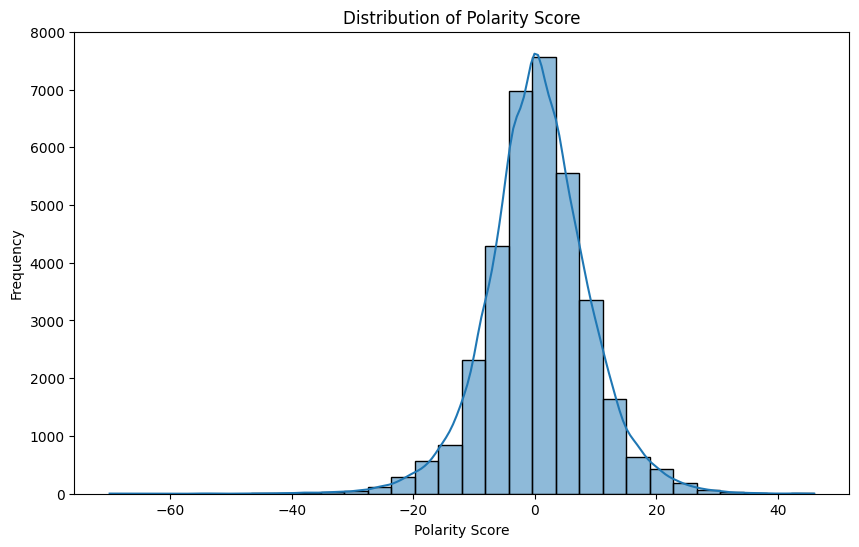

In [16]:
# Menampilkan distribusi polarity_score dengan histogram
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

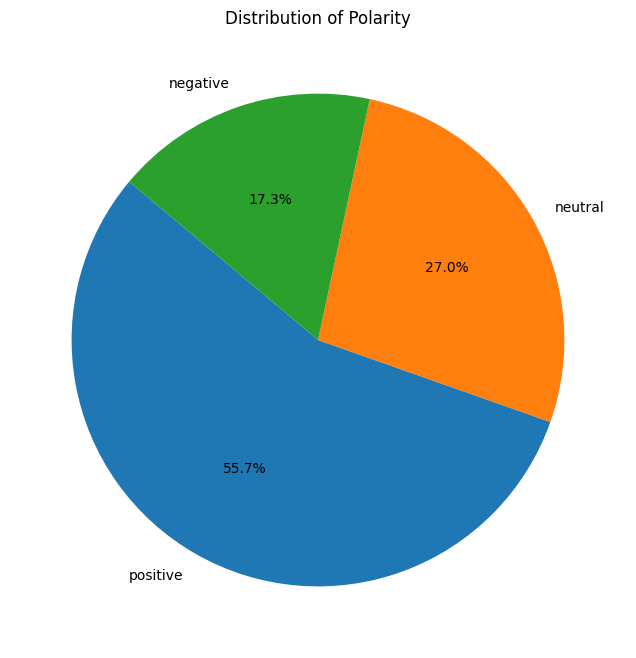

In [52]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()

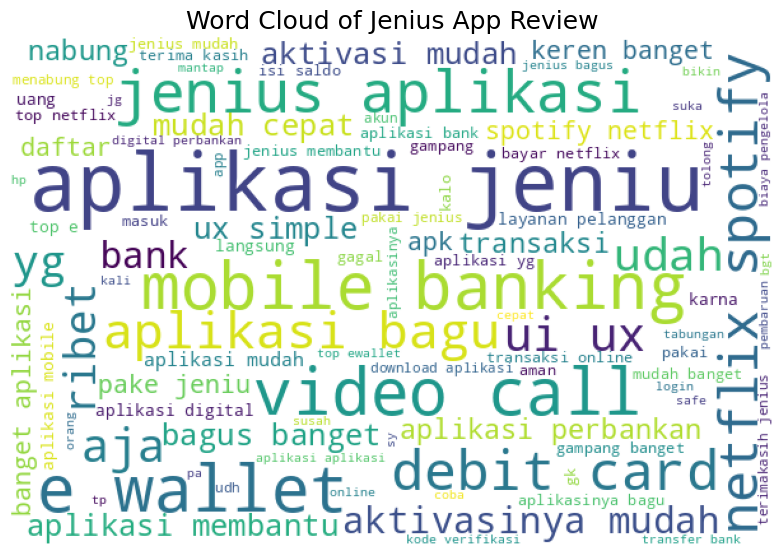

In [53]:
# Membuat wordcloud secara umum

list_words = ''
for tweet in clean_df['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Jenius App Review', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [54]:
# Membuat dataframe untuk wordcloud positive
pd.set_option('display.max_colwidth', 3000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

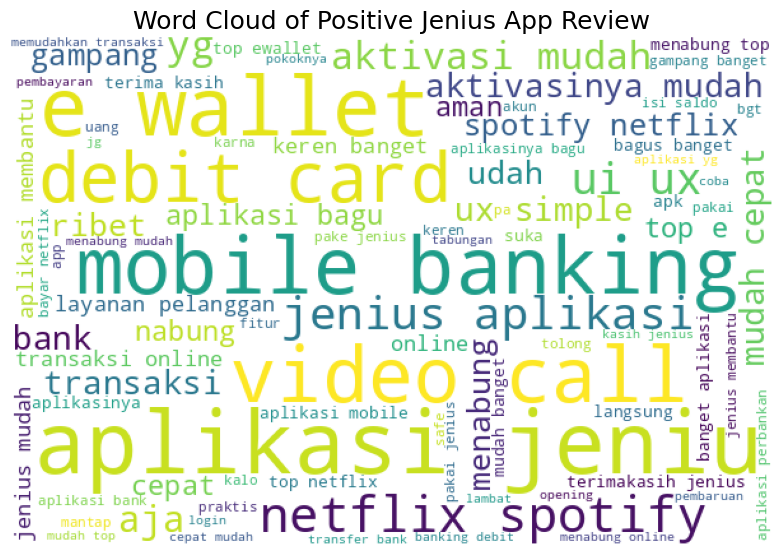

In [55]:
# Menampilkan wordcloud untuk label positive
list_words = ''
for tweet in positive_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Jenius App Review', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

In [56]:
# Membuat dataframe untuk wordcloud negative
pd.set_option('display.max_colwidth', 3000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

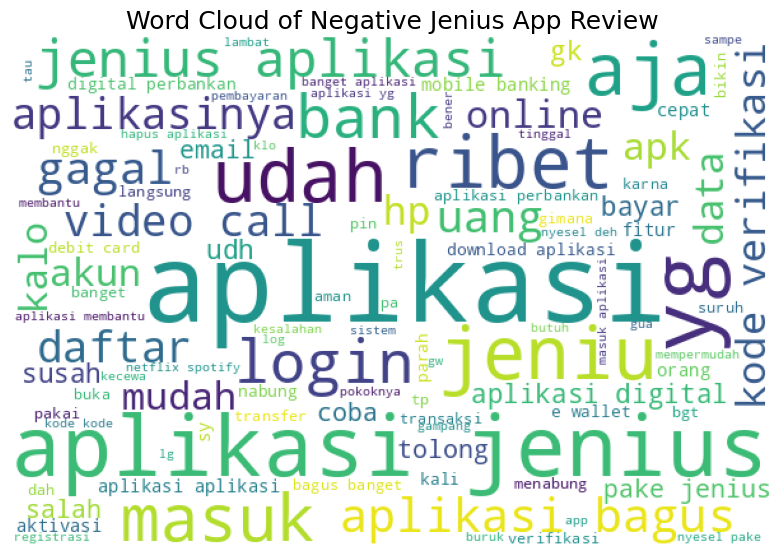

In [57]:
# Menampilkan wordcloud untuk label negative
list_words = ''
for tweet in negative_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Jenius App Review', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

In [58]:
# Membuat dataframe untuk wordcloud neutral
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

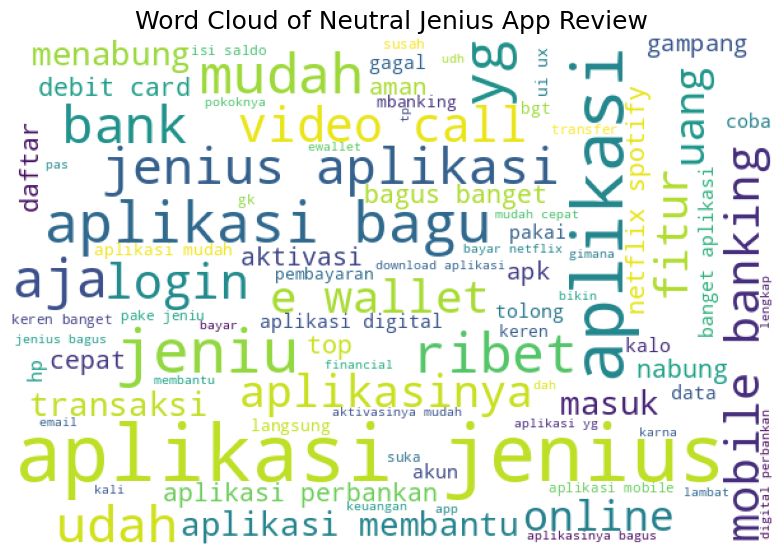

In [59]:
# Menampilkan wordcloud untuk label neutral
list_words = ''
for tweet in neutral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Jenius App Review', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

## Data Visualization

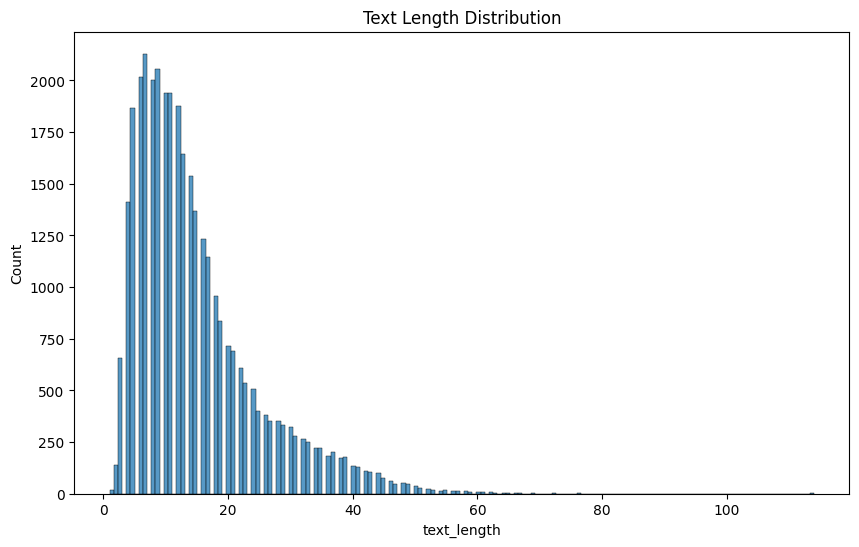

In [50]:
# Menampilkan distribusi dari panjang text
plt.figure(figsize=(10, 6))
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

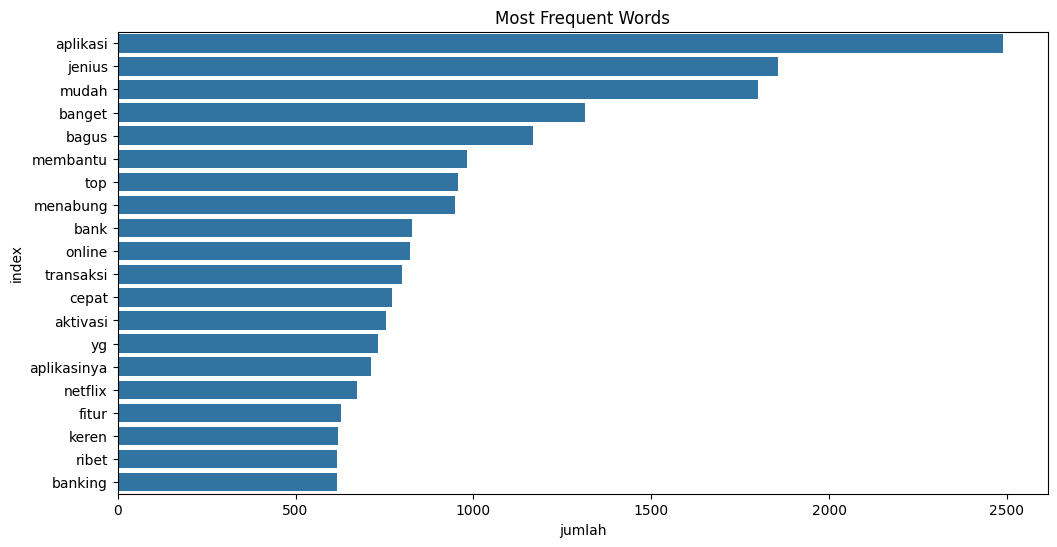

In [51]:
# Menampilkan kata yang paling sering muncul
plt.figure(figsize=(12, 6))
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

## Modelling

In [18]:
# Mengambil kolom text_akhir dan polarity
X = clean_df['text_akhir']
y = clean_df['polarity']

In [19]:
# Tokenisasi
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

In [62]:
# Mengatur early stopping
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.99999:
            print(f"\nVal accuracy telah melebihi 0.99999, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True
early_stopping = CustomCallback()

### **Model 1 - CNN**

In [42]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42)

In [43]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_CNN.add(Conv1D(128, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(128, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))

# Kompilasi model
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Melatih model
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history_CNN = model_CNN.fit(X_train_CNN, y_train_CNN, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_CNN, y_val_CNN))

Epoch 1/50
416/416 - 8s - 19ms/step - accuracy: 0.6182 - loss: 0.8350 - val_accuracy: 0.7800 - val_loss: 0.5256
Epoch 2/50
416/416 - 7s - 17ms/step - accuracy: 0.8294 - loss: 0.4129 - val_accuracy: 0.8829 - val_loss: 0.3171
Epoch 3/50
416/416 - 3s - 7ms/step - accuracy: 0.8908 - loss: 0.2832 - val_accuracy: 0.8793 - val_loss: 0.2940
Epoch 4/50
416/416 - 5s - 13ms/step - accuracy: 0.9153 - loss: 0.2306 - val_accuracy: 0.8964 - val_loss: 0.2658
Epoch 5/50
416/416 - 5s - 12ms/step - accuracy: 0.9343 - loss: 0.1895 - val_accuracy: 0.9064 - val_loss: 0.2530
Epoch 6/50
416/416 - 3s - 7ms/step - accuracy: 0.9417 - loss: 0.1652 - val_accuracy: 0.9121 - val_loss: 0.2403
Epoch 7/50
416/416 - 3s - 7ms/step - accuracy: 0.9519 - loss: 0.1416 - val_accuracy: 0.9064 - val_loss: 0.2589
Epoch 8/50
416/416 - 5s - 12ms/step - accuracy: 0.9636 - loss: 0.1157 - val_accuracy: 0.9143 - val_loss: 0.2513
Epoch 9/50
416/416 - 3s - 7ms/step - accuracy: 0.9691 - loss: 0.0994 - val_accuracy: 0.9086 - val_loss: 0.2

In [44]:
# Evaluasi model pada data pelatihan dan pengujian
score_train_CNN, acc_train_CNN = model_CNN.evaluate(X_train_CNN, y_train_CNN, verbose=2, batch_size=batch_size)
score_test_CNN, acc_test_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2, batch_size=1028)

print("Train score: %.2f" % (score_train_CNN))
print("Train accuracy: %.2f" % (acc_train_CNN))
print("Test score: %.2f" % (score_test_CNN))
print("Test accuracy: %.2f" % (acc_test_CNN))

416/416 - 1s - 3ms/step - accuracy: 0.9680 - loss: 0.1131
7/7 - 1s - 133ms/step - accuracy: 0.9033 - loss: 0.2577
Train score: 0.11
Train accuracy: 0.97
Test score: 0.26
Test accuracy: 0.90


In [49]:
model_CNN.save('model_CNN.h5')

### **Model 2 - LSTM**

In [36]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42)

In [37]:
# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 128
history_LSTM = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=30, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_LSTM, y_val_LSTM))


Epoch 1/30
234/234 - 162s - 692ms/step - accuracy: 0.5568 - loss: 4.6478 - val_accuracy: 0.5562 - val_loss: 3.3926
Epoch 2/30
234/234 - 217s - 928ms/step - accuracy: 0.6566 - loss: 2.5222 - val_accuracy: 0.7441 - val_loss: 1.7940
Epoch 3/30
234/234 - 169s - 723ms/step - accuracy: 0.7772 - loss: 1.3817 - val_accuracy: 0.8108 - val_loss: 1.0516
Epoch 4/30
234/234 - 135s - 576ms/step - accuracy: 0.8291 - loss: 0.8403 - val_accuracy: 0.8470 - val_loss: 0.6774
Epoch 5/30
234/234 - 137s - 587ms/step - accuracy: 0.8601 - loss: 0.5703 - val_accuracy: 0.8743 - val_loss: 0.5033
Epoch 6/30
234/234 - 134s - 575ms/step - accuracy: 0.8801 - loss: 0.4377 - val_accuracy: 0.8743 - val_loss: 0.4271
Epoch 7/30
234/234 - 143s - 611ms/step - accuracy: 0.8901 - loss: 0.3687 - val_accuracy: 0.8883 - val_loss: 0.3844
Epoch 8/30
234/234 - 134s - 573ms/step - accuracy: 0.8985 - loss: 0.3309 - val_accuracy: 0.8940 - val_loss: 0.3558
Epoch 9/30
234/234 - 135s - 578ms/step - accuracy: 0.9023 - loss: 0.3084 - val_a

In [38]:
# Evaluasi model pada data pelatihan dan pengujian
score_train_LSTM, acc_train_LSTM = model_LSTM.evaluate(X_train_LSTM, y_train_LSTM, verbose=2, batch_size=batch_size)
score_test_LSTM, acc_test_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2, batch_size=1028)

print("Train score: %.2f" % (score_train_LSTM))
print("Train accuracy: %.2f" % (acc_train_LSTM))
print("Test score: %.2f" % (score_test_LSTM))
print("Test accuracy: %.2f" % (acc_test_LSTM))


234/234 - 22s - 95ms/step - accuracy: 0.9582 - loss: 0.1673
4/4 - 1s - 126ms/step - accuracy: 0.9263 - loss: 0.2406
Train score: 0.17
Train accuracy: 0.96
Test score: 0.24
Test accuracy: 0.93


In [48]:
model_LSTM.save('model_LSTM.h5')

### **Model 3 - GRU**

In [39]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Membangun model GRU
print("\nBuilding Improved GRU model...")
model_GRU = Sequential()
model_GRU.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.5))
model_GRU.add(Bidirectional(GRU(128, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(256, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(num_classes, activation='softmax'))

# Mengatur optimasi
model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Menyiapkan Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model dengan early stopping kustom
batch_size = 256
history_GRU = model_GRU.fit(
    X_train_GRU,
    y_train_GRU,
    epochs=20,
    batch_size=batch_size,
    verbose=2,
    validation_data=(X_val_GRU, y_val_GRU),
    callbacks=[early_stopping]
)


Building Improved GRU model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


111/111 - 14s - 128ms/step - accuracy: 0.6840 - loss: 2.2446 - val_accuracy: 0.8340 - val_loss: 1.0979
Epoch 2/20
111/111 - 9s - 77ms/step - accuracy: 0.8561 - loss: 0.7733 - val_accuracy: 0.8824 - val_loss: 0.5257
Epoch 3/20
111/111 - 9s - 79ms/step - accuracy: 0.8932 - loss: 0.4433 - val_accuracy: 0.9214 - val_loss: 0.3347
Epoch 4/20
111/111 - 10s - 91ms/step - accuracy: 0.9081 - loss: 0.3350 - val_accuracy: 0.9220 - val_loss: 0.2887
Epoch 5/20
111/111 - 10s - 94ms/step - accuracy: 0.9143 - loss: 0.2915 - val_accuracy: 0.9126 - val_loss: 0.2758
Epoch 6/20
111/111 - 10s - 93ms/step - accuracy: 0.9260 - loss: 0.2536 - val_accuracy: 0.9160 - val_loss: 0.2654
Epoch 7/20
111/111 - 9s - 81ms/step - accuracy: 0.9309 - loss: 0.2334 - val_accuracy: 0.9241 - val_loss: 0.2526
Epoch 8/20
111/111 - 10s - 92ms/step - accuracy: 0.9337 - loss: 0.2205 - val_accuracy: 0.9207 - val_loss: 0.2485
Epoch 9/20
111/111 - 10s - 91ms/step - accuracy: 0.9392 - loss: 0.2065 - val_accuracy: 0.9200 - val_loss: 0.2

In [41]:
# Evaluasi model pada data pelatihan dan pengujian
score_train_GRU, acc_train_GRU = model_GRU.evaluate(X_train_GRU, y_train_GRU, verbose=2, batch_size=batch_size)
score_test_GRU, acc_test_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2, batch_size=1028)

print("Train score: %.2f" % (score_train_GRU))
print("Train accuracy: %.2f" % (acc_train_GRU))
print("Test score: %.2f" % (score_test_GRU))
print("Test accuracy: %.2f" % (acc_test_GRU))


111/111 - 3s - 28ms/step - accuracy: 0.9684 - loss: 0.1305
6/6 - 1s - 101ms/step - accuracy: 0.9234 - loss: 0.2353
Train score: 0.13
Train accuracy: 0.97
Test score: 0.24
Test accuracy: 0.92


In [47]:
# Menyimpan model
model_GRU.save('model_GRU.h5')

## Evaluasi Model

In [75]:
results = {
    "Model": ["CNN", "LSTM", "GRU"],
    "Feature Type": ["Word Embedding", "Word Embedding", "Word Embedding"],
    "Split Ratio (Train/Val/Test)": ["75/5/20", "85/5/10", "80/5/15"],
    "Train Accuracy": [acc_train_CNN, acc_train_LSTM, acc_train_GRU],
    "Test Accuracy": [acc_test_CNN, acc_test_LSTM, acc_test_GRU]
}

# Membuat DataFrame
results_df = pd.DataFrame(results)

# Menampilkan hasil
display(results_df)

,Model,Feature Type,Split Ratio (Train/Val/Test),Train Accuracy,Test Accuracy
0,CNN,Word Embedding,75/5/20,0.968045,0.903286
1,LSTM,Word Embedding,85/5/10,0.958229,0.926286
2,GRU,Word Embedding,80/5/15,0.968438,0.923429


## Inference

In [46]:
# Contoh data baru
new_texts = [
    "Tampilannya jelek banget, aplikasinya ribet, susah, customer service nya galak lagi. Bad banget dh pokoknya!",
    "Fitur-fitur Jenius cukup menarik, tapi masih butuh waktu untuk membiasakan diri dengan navigasi di aplikasinya.",
    "Sangat puas dengan Jenius! Fitur Flexi Saver membantu banget buat nabung dengan mudah, plus gratis biaya admin."
]

# Tokenisasi teks baru
new_sequences = tokenizer.texts_to_sequences(new_texts)
max_sequence_length = X_train_CNN.shape[1]
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Prediksi menggunakan model deep learning
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = model_GRU.predict(new_padded_sequences)

# Konversi prediksi ke label
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

# Invers transformasi ke label asli
predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)


# Menampilkan hasil prediksi
for text, label_LSTM, label_CNN, label_GRU in zip(new_texts, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Text: Tampilannya jelek banget, aplikasinya ribet, susah, customer service nya galak lagi. Bad banget dh pokoknya!
Predicted Label (LSTM): negative
Predicted Label (CNN): negative
Predicted Label (GRU): negative

Text: Fitur-fitur Jenius cukup menarik, tapi masih butuh waktu untuk membiasakan diri dengan navigasi di aplikasinya.
Predicted Label (LSTM): neutral
Predicted Label (CNN): neutral
Predicted Label (GRU): neutral

Text: Sangat puas dengan Jenius! Fitur Flexi Saver membantu banget buat nabung dengan mudah, plus gratis biaya admin.
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): positive



## Create Requierements

In [63]:
!pip freeze > requirements.txt